Import the needed packages and ml modules 

In [1]:
import numpy as np
import pandas as pd

import xarray as xr
import os
import sys

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from  torch.utils.data import TensorDataset
from torchsummary import summary
from sklearn.model_selection import KFold
import torch.nn.functional as F
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline 
import contextily as cx
import folium
import folium.plugins
import pandas as pd
import xarray as xr
import branca
import branca.colormap as cm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-3istd0ga because the default path (/home/naveen.raguramalinga/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Read offshore and onshore data

In [2]:
import sys

# Replace 'path_to_directory' with the actual path of the directory containing your Python file
sys.path.append('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/WC')

import experiment as exp


/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/scripts/WC/experiment.py:37: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(project="naveenragur/ML4Sicily",


https://app.neptune.ai/naveenragur/ML4Sicily/e/MLTSU-257


In [3]:
try:
    MLDir = os.getenv('MLDir')
    SimDir = os.getenv('SimDir')
    reg = 'CT'
    train_size = '3200'
    test_size = '20430'
    mode = 'test'
    mask_size = '3200'
except:
    raise Exception("*** Must first set variable")

# load test events related parameters
event_list_path = f'{MLDir}/data/events/shuffled_events_test_{reg}_{test_size}.txt'
event_list = np.loadtxt(event_list_path, dtype='str')
n_eve = len(event_list)    

flood_mask = ~np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
zero_mask = np.load(f'{MLDir}/data/processed/zero_mask_{reg}_{mask_size}.npy')
nflood_grids = np.count_nonzero(flood_mask)

# Define the model region related size/architecture
if reg == 'SR':
   GaugeNo = list(range(53,58)) #rough pick for Siracusa
   x_dim = 1300  #lon
   y_dim = 948 #lat
   ts_dim = len(GaugeNo) #no of gauges time series
   reg_gaugeno = str(54)
   control_points = [[37.01,15.29],
      [37.06757,15.28709],
      [37.05266,15.26536],
      [37.03211,15.28632]]
elif reg == 'CT':
   GaugeNo = list(range(35,44)) #for Catania
   x_dim = 912
   y_dim = 2224
   ts_dim = len(GaugeNo)
   reg_gaugeno = str(41)
   control_points =  [[37.5022,15.0960],
      [37.48876,15.08936],
      [37.47193,15.07816],
      [37.46273,15.08527],
      [37.46252,15.08587],
      [37.45312,15.07874],
      [37.42821,15.08506],
      [37.40958,15.08075],
      [37.38595,15.08539],
      [37.35084,15.08575],
      [37.33049,15.07029],]
   
pts = 480

# Load the model inputs for test events
t_array, red_d_array, red_dZ_array = exp.read_memmap(MLDir=MLDir,
                                                      reg=reg,
                                                      train_size=0,
                                                      test_size=test_size,
                                                      ts_dim=ts_dim,
                                                      pts_dim=pts,
                                                      n_eve = n_eve,
                                                      nflood_grids = nflood_grids,
                                                      what4 = mode,
                                                      normalize = False,
                                                      standardize = False)




reading memmap for test data size: 20430


Autoencoder model for offshore to onshore time series

In [4]:
#build the offshore model
class Autoencoder_offshore(nn.Module):
    def __init__(self,
                 ninputs=5, #number of input channels or gauges
                 t_len = 480, #number of time steps
                 ch_list = [32,64,96], #number of channels in each layer
                 zdim = 50):#number of latent variables
        
        super(Autoencoder_offshore, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.ch_list = ch_list

        # define encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(ninputs, ch_list[0], kernel_size=3, padding=1),   
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(ch_list[0], ch_list[1], kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(ch_list[1], ch_list[2], kernel_size=3, padding=1),
            nn.LeakyReLU(negative_slope=0.5,inplace=True),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.1),
            nn.Flatten(),
            nn.Linear(int(t_len*ch_list[-1]/(2**len(ch_list))), zdim),          
        )

        # define decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(zdim,int(t_len*ch_list[-1]/(2**len(ch_list)))),
            nn.Unflatten(1, (ch_list[-1], int(t_len/(2**len(ch_list))))) ,
            nn.ConvTranspose1d(ch_list[2], ch_list[1], kernel_size=4, padding=1, stride= 2),  
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[1], ch_list[0], kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
            nn.ConvTranspose1d(ch_list[0], ninputs, kernel_size=4, padding=1, stride= 2), 
            nn.LeakyReLU(negative_slope=0.5,inplace=True) ,
        )

    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        x = self.decode(x)
        return x

#build the onshore model
class Autoencoder_onshore(nn.Module):
    def __init__(self,
                 xy, #number of input channels or grids for flooding
                 zlist = [32,64,128]): #number of channels in each layer
        super(Autoencoder_onshore, self).__init__()
        # more channels mean more fine details, more resolution 
        # less channel and layers less likely to overfit so better maximas and minimas
        # more accuracy but slower and more memory and data needed to train
        self.xy = xy
        
        # define encoder layers
        if len(zlist) == 1:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
        elif len(zlist) == 2:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[1], zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
        elif len(zlist) == 3:
            self.encoder = nn.Sequential(          
                nn.Linear(xy, zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[1], zlist[2]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )
            self.decoder = nn.Sequential(
                nn.Linear(zlist[2], zlist[1]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[1], zlist[0]),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
                nn.Linear(zlist[0], xy),
                nn.LeakyReLU(negative_slope=0.01,inplace=True),
            )

    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)  
        x = self.decode(x)
        return x

#build the coupled model
class Autoencoder_coupled(nn.Module):
    def __init__(self,
                offshore_model,
                onshore_model,
                deform_model,
                interface_layers,
                tune_layer):
        super(Autoencoder_coupled, self).__init__()

        # Pretrained offshore 
        self.offshore_encoder = offshore_model.encoder
        for i, layer in enumerate(self.offshore_encoder):
            if i < len(self.offshore_encoder) - tune_layer: #all layers except last
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters(): #last layer
                    param.requires_grad = True

        # Pretrained deform 
        self.deform_encoder = deform_model.encoder
        for i, layer in enumerate(self.deform_encoder):
            if i < len(self.deform_encoder) - tune_layer: #all layers except last
                for param in layer.parameters():
                    param.requires_grad = False
            else:
                for param in layer.parameters(): #last layer
                    param.requires_grad = True

        # Interface
        if interface_layers == 1:
            self.connect = nn.Sequential(
                                nn.Linear(
                                    in_features=64, out_features=64
                                ),
                                nn.ReLU(),
            ) 
        elif interface_layers == 2:    
            self.connect = nn.Sequential(
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
                                    nn.Linear(
                                        in_features=64, out_features=64
                                    ),
                                    nn.LeakyReLU(inplace=True),
            )
        # Pretrained onshore model
        self.onshore_decoder = onshore_model.decoder 
        for i, layer in enumerate(self.onshore_decoder):
            if i < tune_layer:
                for param in layer.parameters(): #first layer
                    param.requires_grad = True
            else:
                for param in layer.parameters(): #all layers except first
                    param.requires_grad = False

    def forward(self, x, dz):
        x = self.offshore_encoder(x)
        # dz = self.deform_encoder(dz)
        # x = torch.cat((x, dz), dim=1)
        # x = self.connect(x)
        # x = torch.sub(x, dz)
        x = self.onshore_decoder(x)
        return x

In [5]:
exp.set_seed_settings(0)

z = 64
channels_off = [64,128,256]
channels_on = [64,64]
channels_deform = [64,64]

exp.run.stop() #stop neptune run and sync files

cuda is: False
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 9 operations to synchronize with Neptune. Do not kill this process.
All 9 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/naveenragur/ML4Sicily/e/MLTSU-257/metadata


ADD RESULTS

In [6]:
#read reconstructions and scores
recon_data = np.load(f'{MLDir}/model/{reg}/out/recon_data_{reg}_{test_size}.npy')
r2_scores_out = np.load(f'{MLDir}/model/{reg}/out/r2_scores_{reg}_{test_size}.npy')
Gfit_out = np.load(f'{MLDir}/model/{reg}/out/Gfit_{reg}_{test_size}.npy')

#load from file
true_pred_er = np.loadtxt(f"./../../model/{reg}/out/er_coupled_finetuned_epoch_min.csv",delimiter=',')
eve_perf = np.loadtxt(f"./../../model/{reg}/out/eve_perf_coupled_finetuned_epoch_min.csv",delimiter=',')

In [7]:
Gfit_out.mean()

0.0493830904643287

ANALYSIS AND PLOTTING

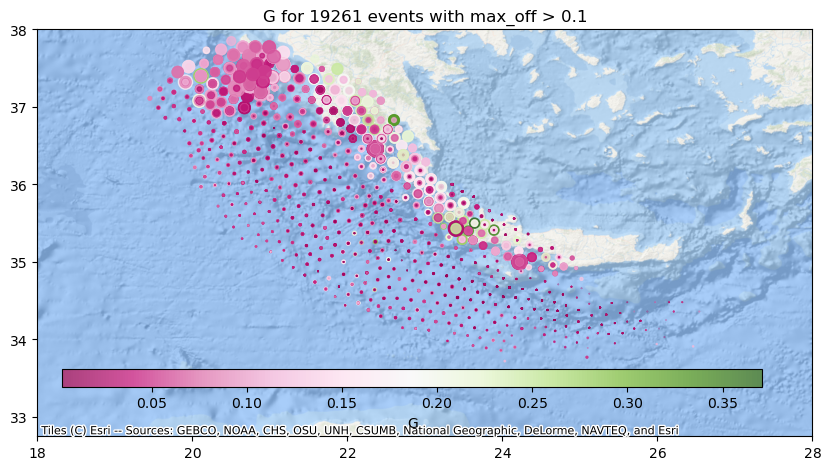

In [8]:
#plot events with lat lon and r2score as color
#load file
sample_test = pd.read_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/PStrue_pred_er_r2scores.csv')

sample_test = sample_test[sample_test['max_off'] > 0.1]

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Set the title
ax.set_title('G for ' + str(len(sample_test)) + ' events with max_off > 0.1')

# Create a scatter plot
scatter = ax.scatter(sample_test['lon'], sample_test['lat'], c=sample_test['gfit_out'],
                      cmap='PiYG', s=sample_test['mean_prob'] * 5000000, alpha=0.75)

# Set the plot limits
plt.xlim(18, 28)
plt.ylim(32.75, 38)

# Add a basemap
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.Esri.OceanBasemap)

# Position the colorbar inside the map plot
cax = fig.add_axes([0.15, 0.275, 0.7, 0.025])  # Adjust the position as needed
cbar = plt.colorbar(scatter, cax=cax, orientation='horizontal', label='G')

# Show the plot
plt.show()


In [9]:
#load exposure values of pop and buildings at each location represented by lat lon of area 10m x 10m
exposure = pd.read_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/resources/gis/exposure/ExposureTable.csv')
exposure['GHSPop1'] = exposure['GHSPop1']/100

total population in flood envelop: 426262.89170529624
total unbuilt area in flood envelop: 30886500
total residential area in flood envelop: 9703900
total non residential area in flood envelop: 1041400


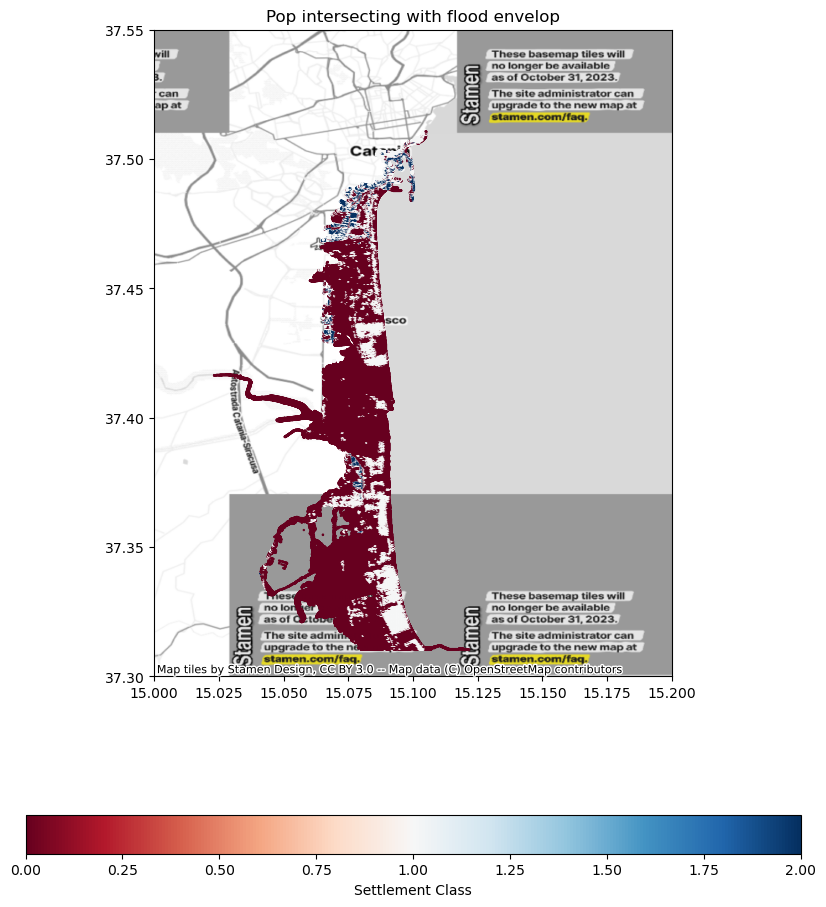

In [10]:
print('total population in flood envelop:',np.sum(exposure['GHSPop1'])*100)
print('total unbuilt area in flood envelop:',np.sum(exposure['Built1']==0)*100)
print('total residential area in flood envelop:',np.sum(exposure['Built1']==1)*100)
print('total non residential area in flood envelop:',np.sum(exposure['Built1']==2)*100)

#plot pop and build exposure using lat lon and exposure values
fig, ax = plt.subplots(figsize=(10,12))
ax.title.set_text('Pop intersecting with flood envelop')
ax = plt.scatter(exposure['field_4'], exposure['field_3'],c=exposure['Built1'],
                  cmap='RdBu',s=0.51)
plt.colorbar(ax, label='Settlement Class', orientation='horizontal')
plt.xlim(15, 15.2)
plt.ylim(37.3, 37.55)
ax = plt.gca()
cx.add_basemap(ax,crs='EPSG:4326', source=cx.providers.Stamen.TonerLite)
plt.show()

In [13]:
threshold = 0.2
#calculate loss estimate per flood event using pop and build exposure using 3 depth bins: 0.2,1,3
def cal_impact(eve,exptype,var): #var: pop or build

    exp = exposure[exptype]
    if var == 'true':
        val= red_d_array[eve,:] 
    elif var == 'pred':
        val = recon_data[eve,:]
    
    print('exp type and total:',exptype,np.sum(exp))
    print('loss for :',var)
    # print(exp.shape)
    # print(val.shape)

    #set true and pred value less than threshold to zero
    val[val<threshold] = 0
    loss_ratio = [0,0.3,0.5,1]
    depth_bins = [0.2,1,3]

    #calculate loss estimate per flood event using pop and build exposure using 3 depth bins: threshold ie 0.1,1,3
    loss = []
    safe = []
    low = []
    medium = []
    high = []

    if  exptype == 'GHSPop1':
        safe = np.sum(exp[(val<=depth_bins[0])])
        low = np.sum(exp[(val>depth_bins[0]) & (val<=depth_bins[1])])
        medium = np.sum(exp[(val>depth_bins[1]) & (val<=depth_bins[2])])
        high = np.sum(exp[(val>depth_bins[2])])
        
    elif exptype == 'Built1':
        safe = np.sum(exp[(val<=depth_bins[0])])
        low = np.sum(exp[(val>depth_bins[0]) & (val<=depth_bins[1])])*loss_ratio[1]
        medium = np.sum(exp[(val>depth_bins[1]) & (val<=depth_bins[2])])*loss_ratio[2]
        high = np.sum(exp[(val>depth_bins[2])])*loss_ratio[3]
    total = low + medium + high
    
    return safe,low,medium,high,total


-0.064476505
0.00746534102627372


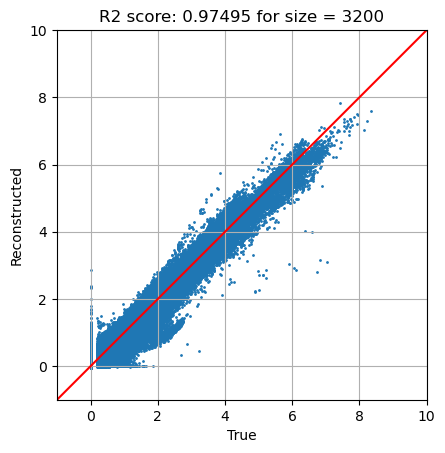

-----------------
exp type and total: GHSPop1 4262.628917052963
loss for : true
(2108.3300283450353, 756.5697466577961, 1278.7771701055626, 118.95197194456797, 2154.298888707927)
exp type and total: GHSPop1 4262.628917052963
loss for : pred
(2064.71809693687, 783.3428564020815, 1288.0816938616829, 126.48626985232826, 2197.9108201160925)
-----------------
exp type and total: Built1 117867
loss for : true
(38639, 8407.5, 22122.0, 6959, 37488.5)
exp type and total: Built1 117867
loss for : pred
(37430, 8637.0, 22215.0, 7217, 38069.0)


In [14]:
eve_no = 1795
print(min(recon_data[eve_no,:]))
print(Gfit_out[eve_no])

plt.scatter(red_d_array[eve_no,:], recon_data[eve_no,:], s=1)
plt.title(f"R2 score: {r2_score(red_d_array[eve_no,:], recon_data[eve_no,:]):.5f} for size = {train_size}")
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='red')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1, 10)
plt.ylim(-1, 10)
plt.grid()
plt.xlabel('True')
plt.ylabel('Reconstructed')
plt.show()
print('-----------------')
print(cal_impact(eve_no,'GHSPop1','true'))
print(cal_impact(eve_no,'GHSPop1','pred'))
print('-----------------')
print(cal_impact(eve_no,'Built1','true'))
print(cal_impact(eve_no,'Built1','pred'))

CLASSIFICATION

exp type and total: GHSPop1 4262.628917052963
254367 246638 1.0313374257008248


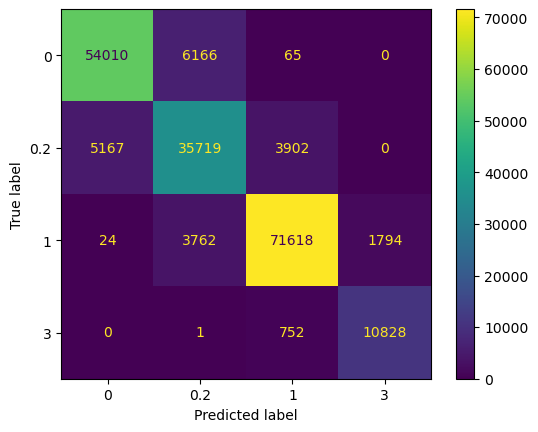

accuracy score: 0.8883792206720053
balanced accuracy score: 0.8891940578746139


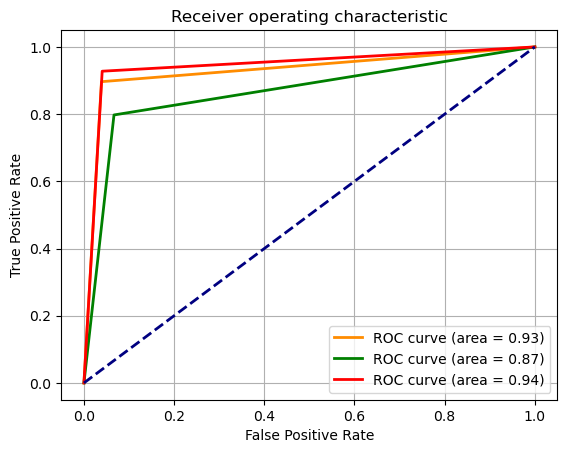

2064.7180969368696 783.3428564020817 1288.0816938616827 126.48626985232826 2197.9108201160925 4262.628917052962


In [138]:
#define function to classify flood grids as safe,low,medium,high based on depth for pop exposure grids
def classify_flood_grids(eve_no,exposure2use):

    depth_bins=[0,0.2,1,3]
    loss_ratio = [0,0.3,0.5,1]

    #set exposure to use
    # exp = exposure[exposure2use]
    exp = exposure[exposure[exposure2use] > 0]
    exp = exp[exposure2use]

    print('exp type and total:',exposure2use,np.sum(exp))


    #set true and pred value less than threshold to zero
    true = red_d_array[eve_no,:]
    pred = recon_data[eve_no,:]
    true[true<threshold] = 0
    pred[pred<threshold] = 0

    print(np.count_nonzero(true),np.count_nonzero(pred),np.count_nonzero(true)/np.count_nonzero(pred))

    #filter out grids using exposure idx column ie where exposure is not zerop
    true = true[exp.index]
    pred = pred[exp.index]

    #classify grids based on depth as safe,low,medium,high using np.digitize
    true_class = np.digitize(true,depth_bins)
    pred_class = np.digitize(pred,depth_bins)

    #calculate confusion matrix using sklearn
    cm = confusion_matrix(true_class, pred_class)


    #plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=depth_bins)
    disp.plot()
    plt.show()

    #calculate accuracy score
    print('accuracy score:',accuracy_score(true_class, pred_class))
    print('balanced accuracy score:',balanced_accuracy_score(true_class, pred_class))

    #plot AUC ROC curve

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(1,4):
        fpr[i], tpr[i], _ = roc_curve(true_class == i, pred_class == i)
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    plt.plot(fpr[1], tpr[1], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
    plt.plot(fpr[2], tpr[2], color='green',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot(fpr[3], tpr[3], color='red',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
      
    #calculate loss estimate per flood event using pop and build exposure using 3 depth bins: threshold ie 0.1,1,3
    if exposure2use == 'GHSPop1':
        safe = np.sum(exp[(pred<=depth_bins[1])])
        low = np.sum(exp[(pred>depth_bins[1]) & (pred<=depth_bins[2])])
        medium = np.sum(exp[(pred>depth_bins[2]) & (pred<=depth_bins[3])])
        high = np.sum(exp[(pred>depth_bins[3])])
        total = low + medium + high
        print(safe,low,medium,high,total,total+safe)
    
    elif exposure2use == 'Built1':
        safe = np.sum(exp[(pred<=depth_bins[1])])
        low = np.sum(exp[(pred>depth_bins[1]) & (pred<=depth_bins[2])])
        medium = np.sum(exp[(pred>depth_bins[2]) & (pred<=depth_bins[3])])
        high = np.sum(exp[(pred>depth_bins[3])])
        total = low + medium + high
        print(safe,low,medium,high,total)

classify_flood_grids(1795,'GHSPop1')


In [129]:
np.sum(exposure['GHSPop1'])

4262.628917052963

In [130]:
#define function to classify flood grids as safe,low,medium,high based on depth for pop exposure grids
def classify_flood_grids_pop(eve_no,exp):

    depth_bins=[0,0.2,1,3]
    loss_ratio = [0,0.3,0.5,1]

    #set true and pred value less than threshold to zero
    true = red_d_array[eve_no,:]
    pred = recon_data[eve_no,:]
    true[true<threshold] = 0
    pred[pred<threshold] = 0

    #filter out grids using exposure idx column ie where exposure is not zerop
    true = true[exp.index]
    pred = pred[exp.index]

    #classify grids based on depth as safe,low,medium,high using np.digitize
    true_class = np.digitize(true,depth_bins)
    pred_class = np.digitize(pred,depth_bins)

    #predicted
    safe = np.sum(exp[(pred<=depth_bins[1])])
    low = np.sum(exp[(pred>depth_bins[1]) & (pred<=depth_bins[2])])
    medium = np.sum(exp[(pred>depth_bins[2]) & (pred<=depth_bins[3])])
    high = np.sum(exp[(pred>depth_bins[3])])
    total_p = low + medium + high

    #true
    safe = np.sum(exp[(true<=depth_bins[1])])
    low = np.sum(exp[(true>depth_bins[1]) & (true<=depth_bins[2])])
    medium = np.sum(exp[(true>depth_bins[2]) & (true<=depth_bins[3])])
    high = np.sum(exp[(true>depth_bins[3])])
    total_t = low + medium + high

    #calculate accuracy score
    return accuracy_score(true_class, pred_class), total_t, total_p
   

In [131]:
#define function to classify flood grids as safe,low,medium,high based on depth for pop exposure grids
def classify_flood_grids_built(eve_no,exp):

    depth_bins=[0,0.2,1,3]
    loss_ratio = [0,0.3,0.5,1]

    #set true and pred value less than threshold to zero
    true = red_d_array[eve_no,:]
    pred = recon_data[eve_no,:]
    true[true<threshold] = 0
    pred[pred<threshold] = 0

    #filter out grids using exposure idx column ie where exposure is not zerop
    true = true[exp.index]
    pred = pred[exp.index]

    #classify grids based on depth as safe,low,medium,high using np.digitize
    true_class = np.digitize(true,depth_bins)
    pred_class = np.digitize(pred,depth_bins)

    #predicted
    safe = np.sum(exp[(pred<=depth_bins[1])])
    low = np.sum(exp[(pred>depth_bins[1]) & (pred<=depth_bins[2])])*loss_ratio[1]
    medium = np.sum(exp[(pred>depth_bins[2]) & (pred<=depth_bins[3])])*loss_ratio[2]
    high = np.sum(exp[(pred>depth_bins[3])])*loss_ratio[3]
    total_p = low + medium + high

    #true
    safe = np.sum(exp[(true<=depth_bins[1])])
    low = np.sum(exp[(true>depth_bins[1]) & (true<=depth_bins[2])])*loss_ratio[1]
    medium = np.sum(exp[(true>depth_bins[2]) & (true<=depth_bins[3])])*loss_ratio[2]
    high = np.sum(exp[(true>depth_bins[3])])*loss_ratio[3]
    total_t = low + medium + high

    #calculate accuracy score
    return accuracy_score(true_class, pred_class), total_t, total_p
   

In [132]:
#calculate accuracy score for all events using pop exposure
exp = exposure[exposure['GHSPop1'] > 0]
exp = exp['GHSPop1']
tab_pop = []
for i in range(len(sample_test)):
    if i % 1000 == 0:
        print(i)
    eve_no = sample_test.index[i]
    # print(eve_no,classify_flood_grids_pop(eve_no,exp))
    tab_pop.append(classify_flood_grids_pop(eve_no,exp))

#calculate accuracy score for all events using built exposure
exp = exposure[exposure['Built1'] == 1]
exp = exp['Built1']
tab_resi = []
for i in range(len(sample_test)):
    if i % 1000 == 0:
        print(i)
    eve_no = sample_test.index[i]
    # print(eve_no,classify_flood_grids_pop(eve_no,exp))
    tab_resi.append(classify_flood_grids_built(eve_no,exp))

exp = exposure[exposure['Built1'] == 2]
exp = exp['Built1']
tab_nonresi = []
for i in range(len(sample_test)):
    if i % 1000 == 0:
        print(i)
    eve_no = sample_test.index[i]
    # print(eve_no,classify_flood_grids_pop(eve_no,exp))
    tab_nonresi.append(classify_flood_grids_built(eve_no,exp))

#append tab to sample_test and save
sample_test['pop_acc'] = np.array(tab_pop)[:,0]
sample_test['pop_true'] = np.array(tab_pop)[:,1]
sample_test['pop_pred'] = np.array(tab_pop)[:,2]
sample_test['resi_acc'] = np.array(tab_resi)[:,0]
sample_test['resi_true'] = np.array(tab_resi)[:,1]
sample_test['resi_pred'] = np.array(tab_resi)[:,2]
sample_test['nonresi_acc'] = np.array(tab_nonresi)[:,0]
sample_test['nonresi_true'] = np.array(tab_nonresi)[:,1]
sample_test['nonresi_pred'] = np.array(tab_nonresi)[:,2]

sample_test.to_csv('/mnt/beegfs/nragu/tsunami/ML4SicilyTsunami/model/CT/out/PS_pop_resi_non_scores.csv')

0


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


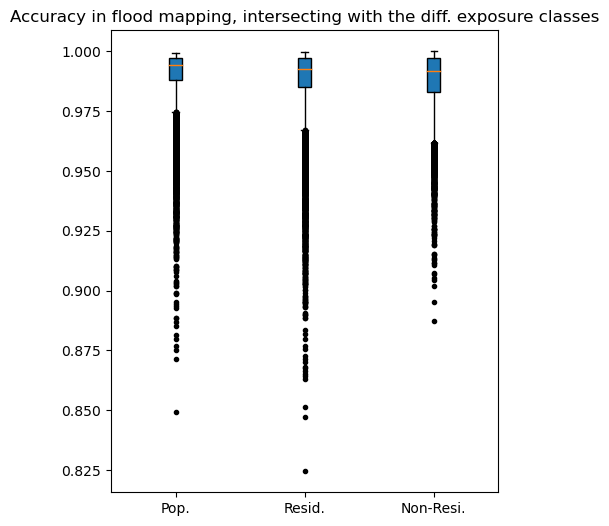

In [133]:
#plot box plot of accuracy score for all events using three exposure classes pop, resi, nonresi
fig, ax = plt.subplots(figsize=(5, 6))
ax.set_title('Accuracy in flood mapping, intersecting with the diff. exposure classes')
ax.boxplot([sample_test['pop_acc'],sample_test['resi_acc'],sample_test['nonresi_acc']],widths=0.1,sym='k.',patch_artist=True)
ax.set_xticklabels(['Pop.','Resid.','Non-Resi.'])
plt.show()


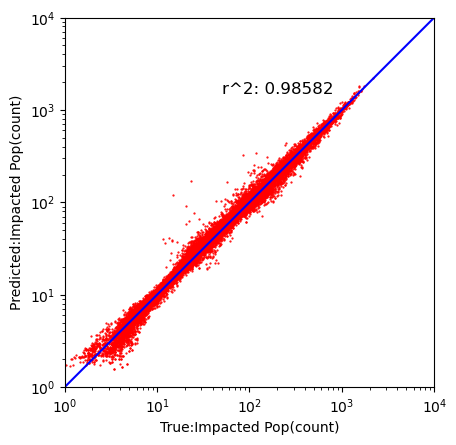

In [134]:

#plot scatter
plt.scatter(sample_test['pop_true'], sample_test['pop_pred'], marker='o', color='red',s=0.33)
plt.text(50,1500, f'r^2: {r2_score(sample_test["pop_true"], sample_test["pop_pred"]):.5f}', fontsize=12)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='blue')
plt.gca().set_aspect('equal', adjustable='box')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 10000)
plt.ylim(1, 10000)
plt.xlabel('True:Impacted Pop(count)')
plt.ylabel('Predicted:Impacted Pop(count)')
plt.show()

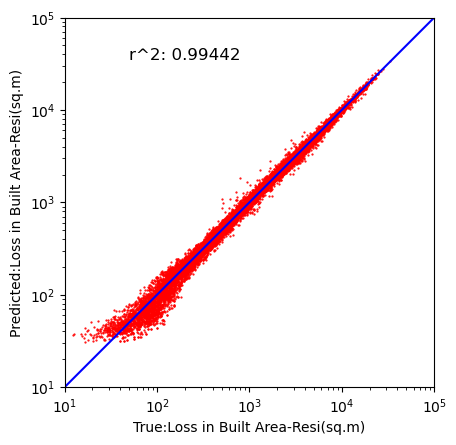

In [135]:
#plot scatter
plt.scatter(sample_test['resi_true'], sample_test['resi_pred'], marker='o', color='red',s=0.33)
plt.text(50,35000, f'r^2: {r2_score(sample_test["resi_true"], sample_test["resi_pred"]):.5f}', fontsize=12)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='blue')
plt.gca().set_aspect('equal', adjustable='box')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10, 100000)
plt.ylim(10, 100000)
plt.xlabel('True:Loss in Built Area-Resi(sq.m)')
plt.ylabel('Predicted:Loss in Built Area-Resi(sq.m)')
plt.show()

Text(0, 0.5, 'Predicted:Loss in Built Area-Non-Resi(sq.m)')

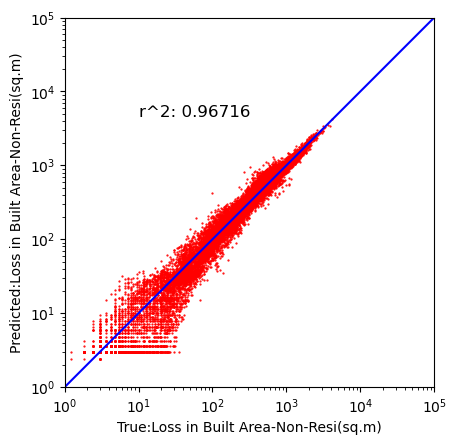

In [136]:
#plot scatter
plt.scatter(sample_test['nonresi_true'], sample_test['nonresi_pred'], marker='o', color='red',s=0.33)
plt.text(10,4500, f'r^2: {r2_score(sample_test["nonresi_true"], sample_test["nonresi_pred"]):.5f}', fontsize=12)
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color='blue')
plt.gca().set_aspect('equal', adjustable='box')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 100000)
plt.ylim(1, 100000)
plt.xlabel('True:Loss in Built Area-Non-Resi(sq.m)')
plt.ylabel('Predicted:Loss in Built Area-Non-Resi(sq.m)')
# plt.show()